In [1]:
import imageio

from deepom.figures import *

# Images_FigureData().make_figure_data()
data = Images_FigureData.load_figure_data()

In [2]:
from matplotlib.ticker import MultipleLocator
from matplotlib_scalebar.scalebar import ScaleBar

data_item = data.data_item
item = data.item
refs = data.refs
inference_item = data.inference_item

scalebar_scale = 130e-9

In [11]:
item.crop_item.parent_bnx_item.bionano_image.endpoints

array([[6656.,  123.],
       [8074.,  128.]])

In [246]:
im = item.crop_item.parent_bnx_item.bionano_image
im.read_jxr_image()
im = im.fov_image
im = rescale_intensity(im, in_range=(250, 600))
imageio.imwrite("../figures/fov_image.jpg", im)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


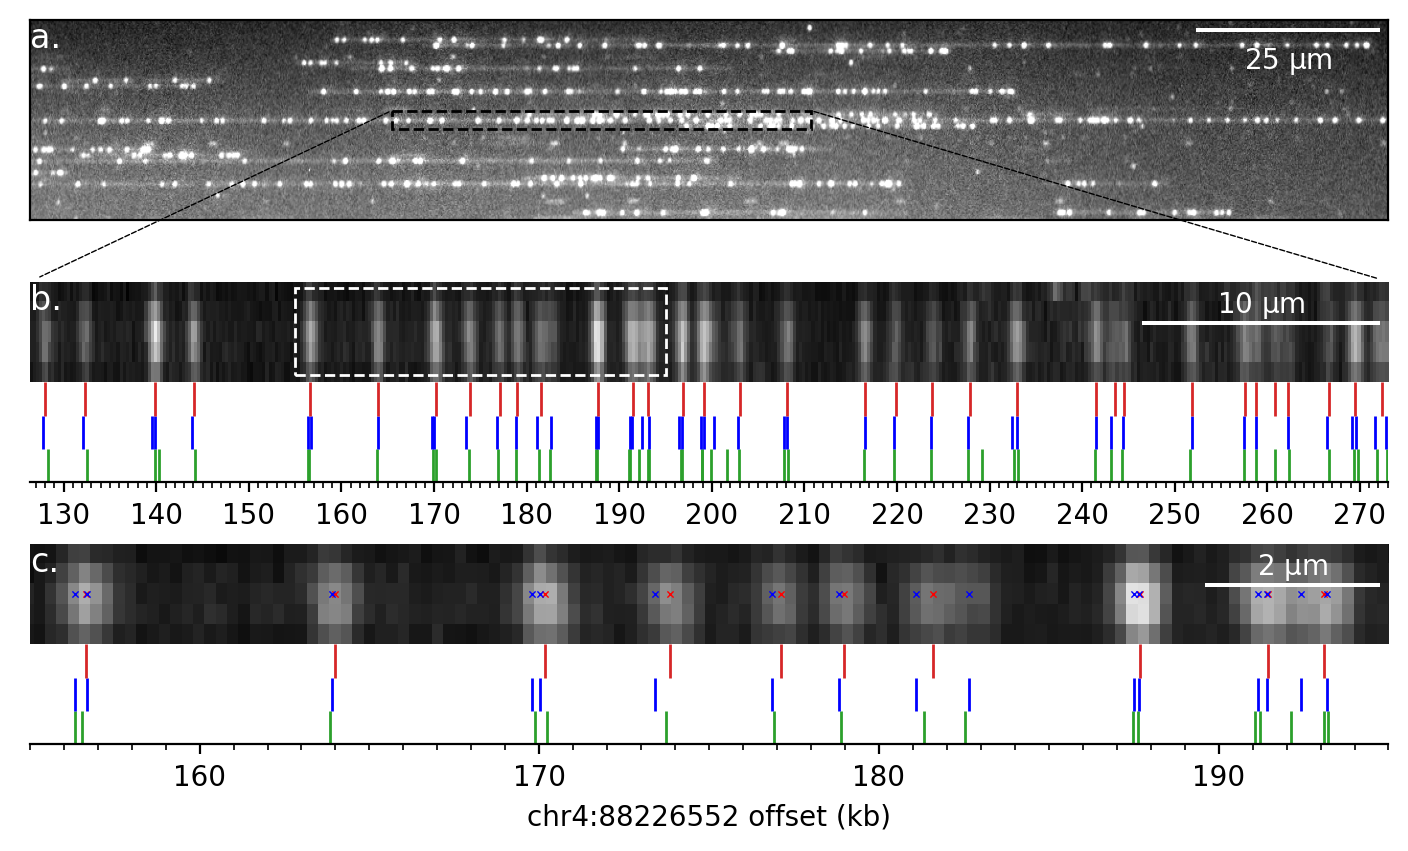

In [277]:

from matplotlib import patches
from matplotlib.patches import Rectangle, ConnectionPatch

# pyplot.rcParams['axes.titley'] = 1.0
# pyplot.rcParams['axes.titley'] = 1.0
_, axs = pyplot.subplots(figsize=(7, 4), dpi=200, nrows=3)

titles = [
    "a.",
    "b.",
    "c.",
]
title_kw = dict(loc="left", y=1.0, pad=-10, fontdict={"color": "w"})

pyplot.sca(axs[0])
pyplot.title("a.", **title_kw)

fov_image = item.crop_item.parent_bnx_item.bionano_image.segment_image[0]
fov_image = fov_image[20: -20]
fov_image = rescale_intensity(fov_image, in_range=(250, 600))

pyplot.imshow(fov_image, cmap="gray", aspect="auto")

pyplot.gca().add_artist(ScaleBar(scalebar_scale, color="w", box_alpha=0, width_fraction=.02))

ax = pyplot.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ilims = 29, 60
margin = 30e3

rvec = refs[item.ref_id]
qvec = item.qry_item.qry

lims = max(0, item.alignment_ref[ilims[0]] - margin), min(rvec.max(), item.alignment_ref[ilims[1]] + margin)
rvec_show = rvec[slice(*rvec.searchsorted(lims))]
offset = item.alignment_ref[ilims[0]] - item.alignment_qry[ilims[0]]
mol_offset = lims[0] - offset
scale = item.qry_item.scale

im_displ = item.qry_item.inference_item.image_input
im_displ = rescale_intensity(im_displ)

h = 15
x, y = (mol_offset / scale, fov_image.shape[0] // 2 - h / 2)
w = (lims[1] - lims[0]) / scale
rect0 = Rectangle((x, y), w, h, edgecolor='k', fill=False, linestyle="--")
ax.add_patch(rect0)
pyplot.sca(axs[1])
pyplot.title("b.", **title_kw)


bionano_locs = item.crop_item.pixel_locs * scale
locs = item.alignment_qry
scatter_kw = dict(marker="x", s=5, alpha=1, linewidths=.5)
def plot_molecule():
    pyplot.imshow(im_displ[::-1], cmap='gray', extent=[0, im_displ.shape[-1] * scale, 3, 6], aspect="auto")

    pyplot.eventplot([rvec_show - offset, locs, bionano_locs],
                     lineoffsets=[.5, 1.5, 2.5], colors=["tab:green", "b", "tab:red"],
                     linelengths=[1, 1, 1], linewidths=1)

    pyplot.xlim(lims[0] - offset, lims[1] - offset)
    pyplot.ylim(0, None)
    set_only_x_visible()
    set_formatter(lambda x, _: int(x / 1000))

    pyplot.gca().add_artist(ScaleBar(scalebar_scale / scale, color="w", box_alpha=0, scale_loc="top", location="upper right", width_fraction=.02, sep=0))


plot_molecule()

zoom_lims = 155 * 1000, 195 * 1000
# for z in zoom_lims:
#     pyplot.axvline(z, ls="--", c="m", lw=2)
ax = pyplot.gca()
margin_rect = .2
rect1 = Rectangle((zoom_lims[0], 3 + margin_rect), (zoom_lims[1] - zoom_lims[0]), 3 - margin_rect * 2,
                      edgecolor='w', fill=False, linestyle="--")
ax.add_patch(rect1)

ax = pyplot.gca()
ax.xaxis.set_major_locator(MultipleLocator(10000))
ax.xaxis.set_minor_locator(MultipleLocator(1000))
pyplot.sca(axs[2])

ax = pyplot.gca()
ax.xaxis.set_major_locator(MultipleLocator(10000))
ax.xaxis.set_minor_locator(MultipleLocator(1000))
# rect1 = Rectangle((zoom_lims[0], 3 + margin_rect), (zoom_lims[1] - zoom_lims[0]), 3 - margin_rect * 2,
#                       edgecolor='w', fill=False, linestyle="--")
# # margin2 = .04
# axs[2].add_patch(rect1)
pyplot.title("c.",  **title_kw)
pyplot.scatter(bionano_locs, [4.5] * len(bionano_locs), c="r", **scatter_kw)
pyplot.scatter(locs, [4.5] * len(locs), c="b", **scatter_kw)
plot_molecule()
pyplot.xlim(*zoom_lims)
# pyplot.subplots_adjust(hspace=.7)
pyplot.tight_layout(pad=.5)
pyplot.xlabel(f"chr{item.ref_id}:{int(offset)} offset (kb)")
fig = pyplot.gcf()
arrow_kw = dict(
    coordsA=axs[0].transData,
    coordsB=axs[1].transAxes,
    shrinkA=1,
    shrinkB=4,
    # Default shrink parameter is 0 so can be omitted
    color="black",
    linestyle="--",
    arrowstyle="-",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
x, y = rect0.xy
w = rect0.get_width()
fig.patches.extend([ConnectionPatch((x, y), (0, 1), **arrow_kw), ConnectionPatch((x + w, y), (1, 1), **arrow_kw)])

for ext in [".pdf", ".jpg"]:
    pyplot.savefig(Path("../../DeepOM-Paper/figures") / ("images_figure" + ext), bbox_inches='tight')